In [1]:
import openeo
from openeo.rest.datacube import PGNode, THIS
from openeo.processes import *
import math

In [3]:
backend = "openeo.cloud"
conn = openeo.connect(backend)
conn = conn.authenticate_oidc()

Authenticated using refresh token.


In [4]:
def vector_cube_pg(bbox = [3, 43, 18, 51], geom = None, temporal_extent = ["2018-05-01", "2018-09-01"]):
    spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
    collection      = 'SENTINEL1_SIG0_20M'
    bands           = ["VV", "VH"]
    properties = {"sat:orbit_state": lambda x: eq(x, "ascending")}

    sig = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent, properties=properties).reduce_dimension(dimension="time", reducer="median")
    
    if not geom:
        geom = sig.process("load_vector_cube", {"URL": "https://raw.githubusercontent.com/openEOPlatform/SRR3_notebooks/main/notebooks/resources/UC8/vector_data/target_canopy_cover_60m_WGS84/target_canopy_cover_WGS84_60m.geojson"})
    sig_agg = sig.aggregate_spatial(geometries=geom, reducer="median") 
    
    
    collection      = 'boa_sentinel_2'
    bands           = ["B02", "B03", "B04"] 

    l2a = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent).reduce_dimension(dimension="t", reducer="median")
        
    l2a_agg = l2a.aggregate_spatial(geometries=geom, reducer="median")
    
    from openeo.rest.datacube import THIS
    
    merge = sig_agg.process("merge_cubes", {"cube1": THIS, "cube2": l2a_agg})

    merge_saved = merge.save_result(format="GeoJSON") 
    
    return merge_saved

In [5]:
job = vector_cube_pg().create_job(title = "UC8-1")
jobId = job.job_id
job.start_job()
print("Jobs submitted: ", jobId)

/home/vhutter/.local/lib/python3.10/site-packages/openeo/rest/connection.py:1188: UserWarning: SENTINEL1_SIG0_20M property filtering with properties that are undefined in the collection metadata (summaries): sat:orbit_state.
  return DataCube.load_collection(
Preflight process graph validation raised: [UpstreamValidationFailure] Validation failed on backend eodc: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='openeo.eodc.eu', port=443): Read timed out. (read timeout=60)"))


Jobs submitted:  eodc-510aa77b-2f69-4018-a2fe-b1eafdef2805


In [6]:
job

<BatchJob job_id='eodc-510aa77b-2f69-4018-a2fe-b1eafdef2805'>

In [45]:
def fit_random_forest_pg(job_id = jobId, geom = None):
    vector_cube = conn.load_stac(url = f'{backend}/jobs/{job_id}/results')
    
    if not geom:
        geom = vector_cube.process("load_vector_cube", {"URL": "https://raw.githubusercontent.com/openEOPlatform/SRR3_notebooks/main/notebooks/resources/UC8/vector_data/target_canopy_cover_60m_WGS84/target_canopy_cover_WGS84_60m.geojson"})
    
    fit = vector_cube.process("fit_regr_random_forest", {"predictors": THIS, "target": geom, "predictors_vars": ["VV", "VH", "B02", "B03", "B04"], "target_var": "target_canopy_cover"})
    fit_saved = fit.save_result(format="GeoJSON") 
    
    return fit_saved

In [46]:
job_rf = fit_random_forest_pg().create_job(title = "UC8-1")
jobId_rf = job_rf.job_id
job_rf.start_job()
print("Jobs submitted: ", jobId_rf)

Jobs submitted:  06615a51-b1b6-4e58-baa6-ad05335e3911


In [49]:
job_rf

<BatchJob job_id='06615a51-b1b6-4e58-baa6-ad05335e3911'>

In [11]:
def predict_rf_pg(job_id = jobId_rf, bbox = [11, 46, 12, 47], temporal_extent = ["2018-08-01", "2018-09-01"]): 
    spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
    collection      = 'SENTINEL1_SIG0_20M'
    bands           = ["VV", "VH"]
    properties = {"sat:orbit_state": lambda x: eq(x, "ascending")}

    sig = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent, properties=properties).reduce_dimension(dimension="time", reducer="median") 

    collection      = 'boa_sentinel_2'
    bands           = ["B02", "B03", "B04"] 

    l2a = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent).reduce_dimension(dimension="t", reducer="median")
    sig_l2a = sig.resample_cube_spatial(target=l2a)
    
    from openeo.rest.datacube import THIS
    
    merge = sig_l2a.merge_cubes(l2a)

    model = conn.load_stac(url = f'{backend}/jobs/{job_id}/results')
    predict = merge.apply_dimension("predict_random_forest", dimension = "bands", target_dimension= "target_canopy_cover", context = {"model": job_id})
    predict_nc = predict.save_result(format="NetCDF")
    
    
    return predict_nc

In [12]:
pg = predict_rf_pg()

job = pg.create_job(title = "UC8-1")
jobId = job.job_id
job.start_job()
print("Jobs submitted: ", jobId)

Preflight process graph validation raised: [404] Load call not available for boa_sentinel_2


Jobs submitted:  02b710de-bd27-4f19-88f1-dfd672256117


In [12]:
job = conn.job("02b710de-bd27-4f19-88f1-dfd672256117")
job

<BatchJob job_id='02b710de-bd27-4f19-88f1-dfd672256117'>

In [13]:
job.get_results().download_files("./UC8/new/")

[PosixPath('UC8/new/EU010M_E049N014T1_NO_TIME.nc'),
 PosixPath('UC8/new/EU010M_E048N015T1_NO_TIME.nc'),
 PosixPath('UC8/new/EU010M_E049N015T1_NO_TIME.nc'),
 PosixPath('UC8/new/EU010M_E048N014T1_NO_TIME.nc'),
 PosixPath('UC8/new/job-results.json')]

In [14]:
import xarray as xr

data = xr.open_dataset("UC8/new/EU010M_E049N014T1_NO_TIME.nc")
display(data)
      

<xarray.Dataset>
Dimensions:              (y: 8162, x: 2337, target_canopy_cover: 1)
Coordinates:
  * y                    (y) float64 1.418e+06 1.418e+06 ... 1.5e+06 1.5e+06
  * x                    (x) float64 4.9e+06 4.9e+06 ... 4.923e+06 4.923e+06
  * target_canopy_cover  (target_canopy_cover) object '0'
    t                    object ...
    spatial_ref          int64 ...
Data variables:
    name                 (target_canopy_cover, y, x) float32 ...

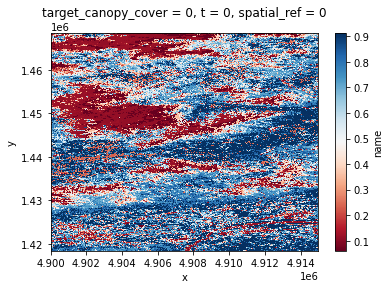

In [19]:
data.name[:,:5000,:1500].plot(cmap="RdBu")